In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [30]:
train = pd.read_csv(r"C:\Users\moham\Desktop\ML project\train.csv")
test = pd.read_csv(r"C:\Users\moham\Desktop\ML project\test.csv")

In [31]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [32]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [34]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [35]:
def extract_title(name):
    if pd.isna(name):
        return "Unknown"
    parts = name.split(',')
    if len(parts) > 1:
        return parts[1].split('.')[0].strip()
    return "Unknown"

In [36]:
train_c=train.copy()

In [37]:
train_c["Title"] = train_c['Name'].apply(extract_title)

In [38]:
train_c["Title"].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [39]:
def preprocess(df):
    df = df.copy()

    # Extract Title
    df['Title'] = df['Name'].apply(extract_title)

    title_map = {
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs',
        'Lady': 'Rare',
        'Countess': 'Rare',
        'Capt': 'Rare',
        'Col': 'Rare',
        'Don': 'Rare',
        'Dr': 'Rare',
        'Major': 'Rare',
        'Rev': 'Rare',
        'Sir': 'Rare',
        'Jonkheer': 'Rare',
        'Dona': 'Rare'
    }
    
    
    df['Title'] = df['Title'].replace(title_map)

    # Family size features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Fill Embarked
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Fill Fare
    if 'Fare' in df.columns:
        df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Fill Age using median by Pclass & Sex
    age_median = df.groupby(['Pclass', 'Sex'])['Age'].transform('median')
    df['Age'] = df['Age'].fillna(age_median)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Drop unused columns
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])

    return df


train_proc = preprocess(train)
test_proc = preprocess(test)

In [40]:
X = train_proc.drop(columns=['Survived'])
y = train_proc['Survived']

# cast some columns to categorical
X['Pclass'] = X['Pclass'].astype(str)
test_proc['Pclass'] = test_proc['Pclass'].astype(str)

X['IsAlone'] = X['IsAlone'].astype(str)
test_proc['IsAlone'] = test_proc['IsAlone'].astype(str)


numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Sex', 'Embarked', 'Pclass', 'Title', 'IsAlone']

In [42]:
num_transformer = SimpleImputer(strategy='median')
cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

In [43]:
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=200, random_state=42)
)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

print("CV Scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

CV Scores: [0.8041958  0.79020979 0.82394366 0.84507042 0.79577465]
Mean accuracy: 0.8118388653599921


In [57]:
model.fit(X_train, y_train)

train_preds = model.predict(X_test)
print("\nTraining accuracy:", accuracy_score(y_test, train_preds))

print("\nConfusion matrix:\n", confusion_matrix(y_test, train_preds))
print("\nClassification report:\n", classification_report(y_test, train_preds))


Training accuracy: 0.8044692737430168

Confusion matrix:
 [[94 16]
 [19 50]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [61]:
final_test = test_proc.copy()
test_preds = model.predict(final_test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_preds
})

submission.to_csv("submission_titanic.csv", index=False)

print("\nSubmission saved as submission_titanic.csv")


Submission saved as submission_titanic.csv


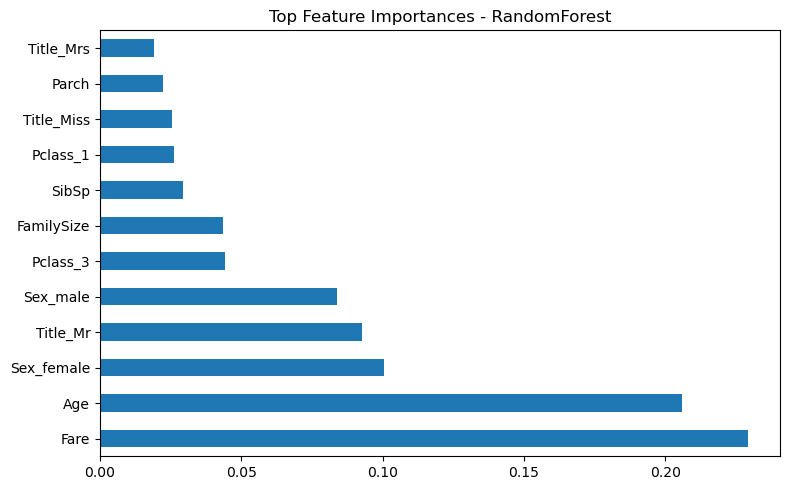

In [62]:
ohe = model.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehotencoder']
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model.named_steps['randomforestclassifier'].feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_series.head(12).plot(kind='barh', figsize=(8, 5))
plt.title("Top Feature Importances - RandomForest")
plt.tight_layout()
plt.show()

In [48]:
def predict_person(model,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name):
    
    data = pd.DataFrame([{
        "Pclass": Pclass,
        "Sex": Sex,
        "Age": Age,
        "SibSp": SibSp,
        "Parch": Parch,
        "Fare": Fare,
        "Embarked": Embarked,
        "Name": Name,
        "Ticket": "0000",
        "Cabin": np.nan
    }])

    data_proc = preprocess(data)

    data_proc["Pclass"] = data_proc["Pclass"].astype(str)
    data_proc["IsAlone"] = data_proc["IsAlone"].astype(str)

    pred = model.predict(data_proc)[0]

    return "Survived" if pred == 1 else "Did NOT Survive"


In [63]:
result = predict_person(
    model=model,
    Pclass=3,
    Sex="male",
    Age=22,
    SibSp=1,
    Parch=0,
    Fare=7.25,
    Embarked="S",
    Name="John, Mr.  Doe",
    )

print(result)


Did NOT Survive


In [64]:
predict_person(
    model,
    Pclass=1,
    Sex="female",
    Age=28,
    SibSp=0,
    Parch=0,
    Fare=80,
    Embarked="C",
    Name="Anna,Mrs.  Smith"
)


'Survived'

In [65]:
model_d = make_pipeline(
    preprocessor,
    DecisionTreeClassifier()
)

In [66]:
model_d.fit(X_train, y_train)

train_preds = model_d.predict(X_test)
print("\nTraining accuracy:", accuracy_score(y_test, train_preds))

print("\nConfusion matrix:\n", confusion_matrix(y_test, train_preds))
print("\nClassification report:\n", classification_report(y_test, train_preds))


Training accuracy: 0.7988826815642458

Confusion matrix:
 [[93 17]
 [19 50]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.75      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



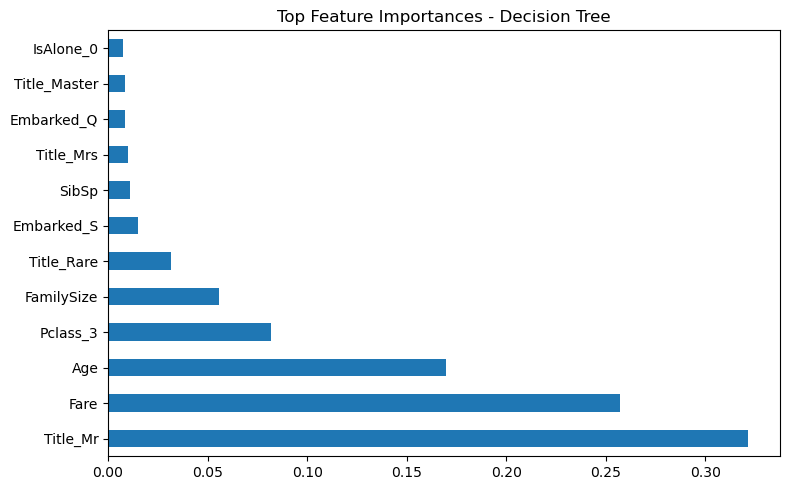

In [60]:
ohe = model_d.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehotencoder']
cat_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_names

importances = model_d.named_steps['decisiontreeclassifier'].feature_importances_
feat_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

feat_series.head(12).plot(kind='barh', figsize=(8, 5))
plt.title("Top Feature Importances - Decision Tree")
plt.tight_layout()
plt.show()